In [1]:
%env ENERGY_PLUS_FOLDER=/Applications/EnergyPlus-8-5-0/
%env DEMO_FILE_FOLDER=/Applications/EnergyPlus-8-5-0/ExampleFiles/BasicsFiles/
%env COMMON_IDD_FILE=/Applications/EnergyPlus-8-5-0/Energy+.idd
%env WEATHER_FILE=/Applications/EnergyPlus-8-5-0/WeatherData/USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw
%env DEMO_FILE=Exercise1A.idf
%env EPLUS2FMU_SCRIPT_FOLDER=/Users/Trondle/Downloads/EnergyPlusToFMU-v2/Scripts

env: ENERGY_PLUS_FOLDER=/Applications/EnergyPlus-8-5-0/
env: DEMO_FILE_FOLDER=/Applications/EnergyPlus-8-5-0/ExampleFiles/BasicsFiles/
env: COMMON_IDD_FILE=/Applications/EnergyPlus-8-5-0/Energy+.idd
env: WEATHER_FILE=/Applications/EnergyPlus-8-5-0/WeatherData/USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw
env: DEMO_FILE=Exercise1A.idf
env: EPLUS2FMU_SCRIPT_FOLDER=/Users/Trondle/Downloads/EnergyPlusToFMU-v2/Scripts


In [2]:
import pandas as pd
from datetime import datetime
import os
import pyfmi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)

## Run Using EnergyPlus

In [3]:
rm -rf ./temp

In [4]:
%%bash
mkdir temp
cd temp
cp $DEMO_FILE_FOLDER/$DEMO_FILE .
sed -i -e 's/Yes,                     !- Run Simulation for Sizing Periods/No,                     !- Run Simulation for Sizing Periods/g' $DEMO_FILE
sed -i -e 's/No;                      !- Run Simulation for Weather File Run Periods/Yes;                      !- Run Simulation for Weather File Run Periods/g' $DEMO_FILE
cat <<EOT >> $DEMO_FILE
  RunPeriod, 
    Annual Simulation, !- Name 
    1, !- Begin Month
    1, !- Begin Day of Month 
    12, !- End Month
    31, !- End Day of Month
    UseWeatherFile, !- Day of Week for Start Day
    Yes, !- Use Weather File Holidays and Special Days 
    Yes, !- Use Weather File Daylight Saving Period 
    No, !- Apply Weekend Holiday Rule
    Yes, !- Use Weather File Rain Indicators 
    Yes; !- Use Weather File Snow Indicators
EOT
energyplus -w $WEATHER_FILE $DEMO_FILE
ReadVarsESO

EnergyPlus Starting
EnergyPlus, Version 8.5.0-c87e61b44b, YMD=2016.08.16 17:11
Processing Data Dictionary
Processing Input File
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=01/21
Continuing Simulation at 01/21 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=02/10
Continuing Simulation at 02/10 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=03/02
Continuing Simulation at 03/02 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=03/22
Continuing Simulation at 03/22 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=04/11
Continuing Simulation at 04/11 for ANNUAL SIMULATION
Updating Shadowing Calculations, Start Date=05/01
Continuing Simulation at 05/01 for ANNUAL SIMULATION
U

In [5]:
def weird_date_parser(date_as_string):
    date, time = date_as_string.split()
    month, day = date.split('/')
    hour, minute, second = time.split(':')
    return datetime(year=2015, 
                    month=int(month), 
                    day=int(day), 
                    hour=int(hour) - 1, 
                    minute=int(minute), 
                    second=int(second))

assert weird_date_parser(" 07/21  01:00:00") == datetime(2015, 7, 21, 0)
assert weird_date_parser(" 07/21  24:00:00") == datetime(2015, 7, 21, 23)

In [6]:
single_run_data = pd.read_csv(
    'temp/eplusout.csv', 
    index_col='Date/Time', 
    parse_dates=True, 
    date_parser=weird_date_parser
)

<class 'pandas.tseries.index.DatetimeIndex'>
[2015-01-01 00:00:00, ..., 2015-12-31 23:00:00]
Length: 8760, Freq: None, Timezone: None

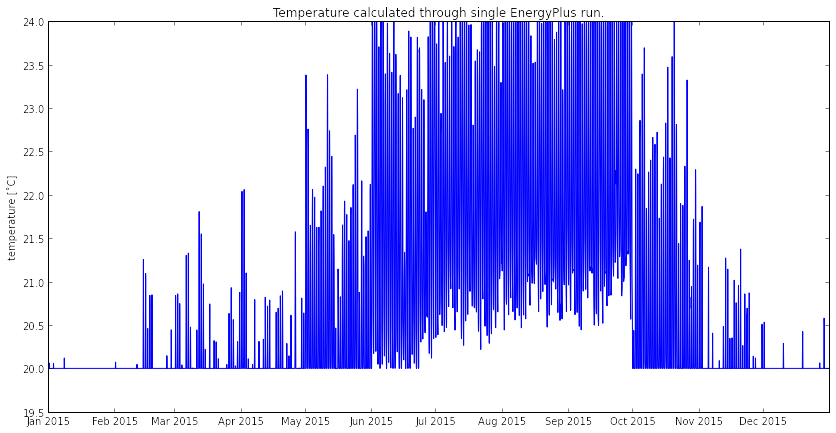

In [21]:
plt.plot(single_run_data.index, single_run_data['ZONE ONE:Zone Air Temperature [C](Hourly)'])
plt.ylabel(u'temperature [˚C]')
plt.title('Temperature calculated through single EnergyPlus run.')

## Create FMU File

In [8]:
rm -rf ./temp

In [9]:
%%bash
mkdir temp
cd temp
cp $DEMO_FILE_FOLDER/$DEMO_FILE .
sed -i -e 's/Yes,                     !- Run Simulation for Sizing Periods/No,                     !- Run Simulation for Sizing Periods/g' $DEMO_FILE
sed -i -e 's/No;                      !- Run Simulation for Weather File Run Periods/Yes;                      !- Run Simulation for Weather File Run Periods/g' $DEMO_FILE
cat <<EOT >> $DEMO_FILE
  RunPeriod, 
    Annual Simulation, !- Name 
    1, !- Begin Month
    1, !- Begin Day of Month 
    12, !- End Month
    31, !- End Day of Month
    UseWeatherFile, !- Day of Week for Start Day
    Yes, !- Use Weather File Holidays and Special Days 
    Yes, !- Use Weather File Daylight Saving Period 
    No, !- Apply Weekend Holiday Rule
    Yes, !- Use Weather File Rain Indicators 
    Yes; !- Use Weather File Snow Indicators
  ExternalInterface,
    FunctionalMockupUnitExport;  !- Name of External Interface

  ExternalInterface:FunctionalMockupUnitExport:From:Variable,
    ZONE ONE, !- EnergyPlus Key Value
    Zone Air Temperature, !- EnergyPlus Variable Name
    AirTemp; !- FMU Variable Name
EOT
python $EPLUS2FMU_SCRIPT_FOLDER/EnergyPlusToFMU.py -i $COMMON_IDD_FILE -w $WEATHER_FILE $DEMO_FILE 

Reading input and weather file for EnergyPlusToFMU program.


clang: warning: argument unused during compilation: '-fast'
/Users/Trondle/Downloads/EnergyPlusToFMU-v2/SourceCode/EnergyPlus/temp-Exercise1A.c:1377:3: warning: '&&' within '||' [-Wlogical-op-parentheses]
                && _c->curComm <=(_c->tStopFMU - 
                ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/Trondle/Downloads/EnergyPlusToFMU-v2/SourceCode/EnergyPlus/temp-Exercise1A.c:1377:3: note: place parentheses around the '&&' expression to silence this warning
                && _c->curComm <=(_c->tStopFMU - 
                ^
1 warning generated.
clang: warning: argument unused during compilation: '-fast'
clang: warning: argument unused during compilation: '-fast'
clang: warning: argument unused during compilation: '-fast'
clang: warning: argument unused during compilation: '-fast'
/Users/Trondle/Downloads/EnergyPlusToFMU-v2/SourceCode/EnergyPlus/xml_parser_cosim.c:427:13: warning: comparison of constant -1 with expression of type 'Elm' is always false [-Wtautological-constant-o

In [10]:
ls -l temp

total 2488
-rw-r--r--  1 Trondle  staff  874987 16 Aug 17:11 Exercise1A.fmu
-rw-r--r--  1 Trondle  staff   20742 16 Aug 17:11 Exercise1A.idf
-rw-r--r--  1 Trondle  staff   20034 16 Aug 17:11 Exercise1A.idf-e
-rwxr-xr-x  1 Trondle  staff  351108 16 Aug 17:11 idf-to-fmu-export-prep-darwin*


## Run FMU Co-Simulation

There are two different types of co-simulation fmu models: one in which the solver is included in the compiled FMU, and one in which the FMU calls another tool (on the command line). PyFMI does not support the latter. EnergyPlus2FMU uses the latter. Hence, PyFMI and EnergyPlus2FMU currently do not work together. [Others have ran into the same probem before and managed to solve it.](https://groups.google.com/forum/#!topic/energyplus-fmu/d9AoiLYoGtk)

The main developer of PyFMI [stated at the end of 2015](http://www.jmodelica.org/27626) that this won't be supported officially antime soon.

The following has been done by patching PyFMI to allow for co-simulation where another tools gets called (_Co-Simulation Tool_). [Patched version is on GitHub](https://github.com/timtroendle/PyFMI/tree/feature-co-tool-support).

In [11]:
DEMO_FILE = (Path('.') / 'temp' / os.environ['DEMO_FILE']).with_suffix('.fmu')
T_START = 0
T_END = 60 * 60 * 24 * 365 # in seconds
T_STEP_SIZE = 900
NUMBER_TIME_STEPS = int((T_END - T_START) / T_STEP_SIZE)
TIME_STEPS = range(T_START, T_END, T_STEP_SIZE)

In [12]:
model = pyfmi.load_fmu(DEMO_FILE.as_posix())
model.instantiate_slave()
model.initialize(T_START, T_END, True)

In [13]:
temp = []
for t in TIME_STEPS:
    temp.append(model.get('AirTemp')[0])
    model.do_step(t, T_STEP_SIZE, new_step=True)

In [14]:
del model

In [15]:
temp = pd.Series(data=temp, index=pd.date_range(start='2015-01-01', end='2015-12-31 23:45', freq="15Min"))

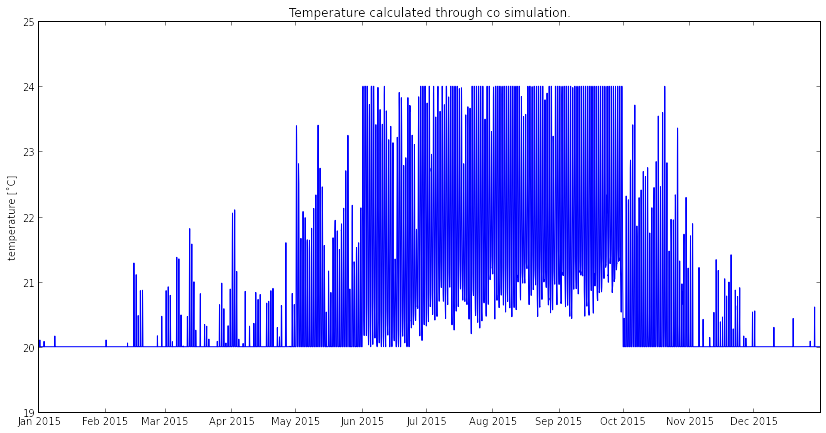

In [20]:
plt.plot(temp.index, temp)
plt.ylabel(u'temperature [˚C]')
plt.title('Temperature calculated through co simulation.')

In [17]:
diff = single_run_data['ZONE ONE:Zone Air Temperature [C](Hourly)'] - temp[:-1].resample('1H')

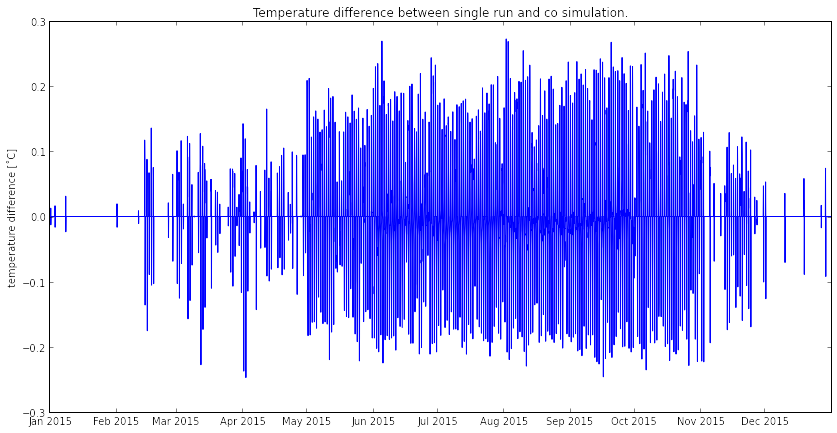

In [22]:
plt.plot(diff.index, diff)
plt.ylabel(u'temperature difference [˚C]')
plt.title('Temperature difference between single run and co simulation.')

In [23]:
diff.sum()

-1.3308465440786676e-11

The difference between the results from the single run and the co simulation seem to be mostly time synch issues; the total difference is 0.

This proof of concept shows that compiling a FMU file out of an IDF file and running it in a Python co-simulation works. It is though rather fragile and involved a code change of one of the Python libraries.